In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

import matplotlib.pyplot as plt
import os
import time

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 8
num_classes = 5
epochs = 400
image_size = (224,224)
lr = 1e-6
patience = 100
validation_split = 0.1
drop_rate = 0.0

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_kaggle_cnn_trained_model.h5'

In [3]:
# make tf allocate gpu memory as needed
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# assign the session with the previous setting as the backend of Keras
tf.keras.backend.set_session(sess)

In [4]:
print('Using real-time data augmentation.')


# train_datagen = ImageDataGenerator(
#     rescale=1./255,
# #     rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
# #     width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
# #     height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
# #         shear_range=0.2,
# #         zoom_range=0.2,
#     horizontal_flip=True,  # randomly flip images
#     validation_split=validation_split,
#     vertical_flip=False
#     )
train_datagen = ImageDataGenerator(
    rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
    zoom_range=0.2,
#     horizontal_flip=True,
    fill_mode='constant',
    validation_split=validation_split,
    cval=0)

train_generator = train_datagen.flow_from_directory(
        'training_set',
        shuffle=True,
#         seed=42,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')


Using real-time data augmentation.
Found 486 images belonging to 5 classes.


In [5]:
valid_datagen = ImageDataGenerator()
# valid_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = train_datagen.flow_from_directory(
        'training_set',
        shuffle=False,
#         seed=42,
        target_size=image_size,
        batch_size=1,
        class_mode='categorical',
        subset='validation')

Found 52 images belonging to 5 classes.


In [6]:
test_datagen = ImageDataGenerator() 
# test_datagen = ImageDataGenerator(rescale=1./255) 

i.shape=  (8, 224, 224, 3)
[0. 0. 0. 0. 1.]


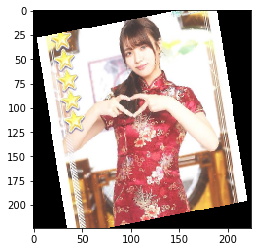

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
i,l = next(train_generator)
print('i.shape= ', i.shape)
print(l[0])
ax = plt.imshow((i[0])/255.)

In [8]:
training_dict = train_generator.class_indices
training_dict = list(training_dict)
training_dict

['akane', 'neru', 'rika', 'risa', 'yui']

In [9]:
import pandas as pd
df = pd.read_csv('classmap.csv')
kaggle_dict = {}
# print(df)
for c in df.values:
    kaggle_dict[c[0]] = c[1]
kaggle_dict

{'rika': 0, 'risa': 1, 'yui': 2, 'akane': 3, 'neru': 4}

In [10]:
print(train_generator.n)
print(len(list(train_generator.class_indices)))
print(validation_generator.n)
print(len(list(validation_generator.class_indices)))

486
5
52
5


In [11]:
##### print('train shape:', image_size)
print(train_generator.n, 'train samples')
print(validation_generator.n, 'test samples')

model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(image_size[0], image_size[1],3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), input_shape=(image_size[0], image_size[1],3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Dense(num_classes))
model.add(BatchNormalization())
model.add(Activation('softmax'))

print(model.summary())
input
# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=lr)

# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Use ModelCheckpoint to save model and weights
# if os.path.exists(save_dir):
#     timestamp = 'saved_models_{:d}'.format(int(time.time()))
#     print("file or directory with the name of ", save_dir, ' exists. use modified name : ', timestamp)
#     save_dir = os.path.join(os.getcwd(), timestamp)
#     os.makedirs(save_dir)
# else:
#     os.makedirs(save_dir)

# model_path = os.path.join(save_dir, model_name)

# checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)


STEPS_PER_EPOCH = train_generator.n // train_generator.batch_size
VALIDATION_STEP = validation_generator.n // validation_generator.batch_size
print('STEPS_PER_EPOCH = ', STEPS_PER_EPOCH)
print('VALIDATION_STEP = ', VALIDATION_STEP)
model_history = model.fit_generator(
                                    generator=train_generator,
                                    steps_per_epoch = STEPS_PER_EPOCH,
                                    validation_data = validation_generator, 
                                    validation_steps = VALIDATION_STEP,
                                    callbacks=[earlystop,checkpoint],
                                    workers=4,
                                    epochs = epochs
                                    )


486 train samples
52 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 224, 224, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 1

# Kaggle core : 47.46%

In [12]:
# loading our save model
print("Loading trained model")
model = load_model(model_path)

# Score trained model.
scores = model.evaluate_generator(generator=validation_generator)

print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Loading trained model
Test loss: 1.045651370802751
Test accuracy: 0.5769230769230769


In [13]:
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import PIL
from PIL import Image
test_dir='testing_set'

ID = []
CLASS = []

files = [join(test_dir, f) for f in listdir(test_dir) if isfile(join(test_dir, f))]

for file in files:
#     print(os.path.splitext(file)[0].split("/")[1])
#     print(file)
    ID.append(os.path.splitext(file)[0].split("/")[1])
    image = Image.open(file)
    image = image.resize(image_size)

    image = np.array(image)

#     image = image / 255.

    if image.shape == image_size:
        gray2RGB = image.reshape(image.shape[0]*image.shape[1],1)
        temp = np.hstack((gray2RGB,gray2RGB))
        gray2RGB = np.hstack((temp,gray2RGB))
        image = gray2RGB.reshape((image.shape[0],image.shape[1],3))
        image = np.expand_dims(image, axis=0)
    else:
#         print("file: ", file, " image shape = ", image.shape)
        image = np.expand_dims(image, axis=0)
    class_id = np.argmax(model.predict(image, batch_size=1))
    
    CLASS.append(kaggle_dict[training_dict[class_id]])
    
# len(ID),len(CLASS)

In [14]:
# idx = 1
# ID[idx],CLASS[idx]

In [15]:
# from os import listdir
# from os.path import isfile, join
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# import pandas as pd
# import PIL
# from PIL import Image


# file = '/home/jovyan/my-workspace/Kaggle_CNN/testset/d9d914fae34406fb2e6e2d3c97fe33b9319733fd121b00ed2acff8be772f1e7e.jpg'

# image = Image.open(file)
# image = image.resize(image_size)
# plt.imshow(image)
# image = np.array(image)
# image = image / 255.

# gray2RGB = image.reshape(image.shape[0]*image.shape[1],1)
# temp = np.hstack((gray2RGB,gray2RGB))
# gray2RGB = np.hstack((temp,gray2RGB))
# image = gray2RGB.reshape((image.shape[0],image.shape[1],3))
# image = np.expand_dims(image, axis=0)
# class_id = kaggle_dict[training_dict[np.argmax(model.predict(image, batch_size=1))]]
# print("class= ", class_id)
    

In [16]:
solution = pd.DataFrame({"ID":ID, "class":CLASS})
solution.to_csv("submission.csv", index = False)